# Environment setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Colab\ Notebooks/ECE219/Project\ 3

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/ECE219/Project 3


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!!pip install lightgbm
!pip install scikit-surprise

In [ ]:
from surprise import Dataset, Reader
from surprise.model_selection import KFold, train_test_split
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD
from surprise.similarities import pearson
from surprise.accuracy import rmse, mae

In [ ]:
from tqdm.auto import tqdm

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, mean_squared_error
from sklearn import model_selection

# Utils

In [ ]:
# The functions below are provided by instructors in ECE219
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import ndcg_score
import numpy as np

# Load the dataset for one fold
def load_one_fold(data_path):
    X_train, y_train, qid_train = load_svmlight_file(str(data_path + 'train.txt'), query_id=True)
    X_test, y_test, qid_test = load_svmlight_file(str(data_path + 'test.txt'), query_id=True)
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    _, group_train = np.unique(qid_train, return_counts=True)
    _, group_test = np.unique(qid_test, return_counts=True)
    return X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test

def dcg_single_query(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

# calculate NDCG score given a trained model
def compute_ndcg_all(model, X_test, y_test, qids_test, k=10):
    unique_qids = np.unique(qids_test)
    ndcg_ = list()
    for i, qid in enumerate(unique_qids):
        y = y_test[qids_test == qid]

        if np.sum(y) == 0:
            continue

        p = model.predict(X_test[qids_test == qid])

        idcg = dcg_single_query(y, y, k=k)
        ndcg_.append(dcg_single_query(p, y, k=k) / idcg)
    return np.mean(ndcg_)

# get importance of features
def get_feature_importance(model, importance_type='gain'):
    return model.feature_importance(importance_type=importance_type)

# Ranking

The dataset is MSLR-WEB10K benchmark.

## Data loading and preprocessing

In [ ]:
WEB10K_data = []
for i in tqdm(range(5)):
    curr_fold = {}
    X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test = load_one_fold(f"MSLR-WEB10K/Fold{i+1}/")
    curr_fold["X_train"] = X_train
    curr_fold["y_train"] = y_train
    curr_fold["qid_train"] = qid_train
    curr_fold["group_train"] = group_train
    curr_fold["X_test"] = X_test
    curr_fold["y_test"] = y_test
    curr_fold["qid_test"] = qid_test
    curr_fold["group_test"] = group_test
    WEB10K_data.append(curr_fold)

  0%|          | 0/5 [00:00<?, ?it/s]

The number of total unique queries is 10000.


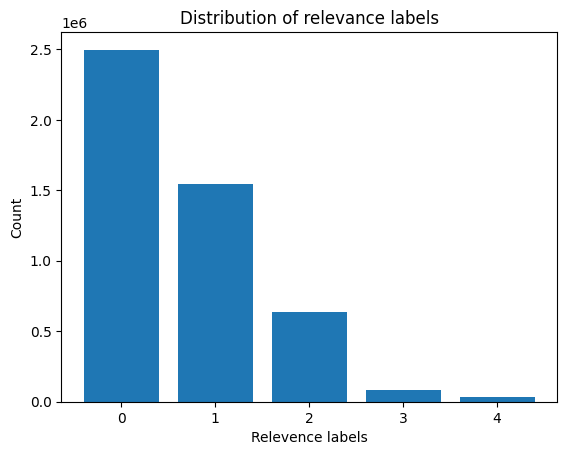

In [ ]:
unique_qid_all = np.unique(np.concatenate([WEB10K_data[i]["qid_train"] for i in range(5)] + [WEB10K_data[i]["qid_test"] for i in range(5)]))
print(f"The number of total unique queries is {len(unique_qid_all)}.")

# plot the distribution of relevance scores
rel_scores, rel_score_counts = np.unique(np.concatenate([WEB10K_data[i]["y_train"] for i in range(5)] + [WEB10K_data[i]["y_test"] for i in range(5)]), return_counts=True)
plt.bar(rel_scores, rel_score_counts)
plt.xlabel('Relevence labels')
plt.ylabel('Count')
plt.title('Distribution of relevance labels')
plt.show()

## LightGBM Model Training 


In [ ]:
import lightgbm as lgb

def train_lightgbm_model(X_train, y_train, group_train, X_test, y_test, qid_test, ks=[3, 5, 10]):
    """
    This function returns the nDCG@k of the trained model for k in ks on the test data.
    """
    # make the training dataset
    train_data = lgb.Dataset(data=X_train, label=y_train, group=group_train)
    # training params
    train_params = {"objective": "lambdarank",
                    "verbose": -1}
    # train the model
    model = lgb.train(train_params, train_data)

    return model, [compute_ndcg_all(model, X_test, y_test, qid_test, k=k) for k in ks]

In [ ]:
for i in tqdm(range(5)):
    _, [ndcg3, ndcg5, ndcg10] = train_lightgbm_model(WEB10K_data[i]["X_train"], WEB10K_data[i]["y_train"], WEB10K_data[i]["group_train"],
                                                     WEB10K_data[i]["X_test"], WEB10K_data[i]["y_test"], WEB10K_data[i]["qid_test"])
    print(f"The model trained on fold {i+1} has nDCG@3 = {ndcg3}, nDCG@5 = {ndcg5}, nDCG@10 = {ndcg10}.")

  0%|          | 0/5 [00:00<?, ?it/s]

The model trained on fold 0 has nDCG@3 = 0.4564571300800643, nDCG@5 = 0.4632890672260867, nDCG@10 = 0.48286731451235976.
The model trained on fold 1 has nDCG@3 = 0.4538895365009714, nDCG@5 = 0.4573292117374164, nDCG@10 = 0.4767546810011047.
The model trained on fold 2 has nDCG@3 = 0.4490681494620125, nDCG@5 = 0.4583480538865081, nDCG@10 = 0.47589507831078093.
The model trained on fold 3 has nDCG@3 = 0.461178820507814, nDCG@5 = 0.4663860127875315, nDCG@10 = 0.487724614983737.
The model trained on fold 4 has nDCG@3 = 0.46963442883961365, nDCG@5 = 0.4714315145908388, nDCG@10 = 0.49035928048966515.


## Result Interpretation 

In [ ]:
def top_features(model, importance_type="gain"):
    """
    It returns a data frame that contains the columns "feature name" and "feature importance scores" sorted by the importance scores.
    """
    features = model.feature_name()
    importances = get_feature_importance(model, importance_type=importance_type)
    feature_importance_df = pd.DataFrame({"features": features, "importance": importances})
    return feature_importance_df.sort_values(by="importance", ascending=False)


def trim_important_features(model, features, trim_size, trim_type="least", importance_type="gain"):
    """
    This function trims the important trim_size features given the importance scores.
    trim_type decides which part of features will be trimmed.
    """
    # sort index by the importances
    importances = get_feature_importance(model, importance_type=importance_type)
    index_sort_by_importances = np.argsort(importances)

    if trim_type == "least":
        index_result = index_sort_by_importances[trim_size:]
    else:
        index_result = index_sort_by_importances[: -trim_size]

    return features[:, index_result]

In [ ]:
from IPython.display import display

for i in tqdm(range(5)):
    model, _ = train_lightgbm_model(WEB10K_data[i]["X_train"], WEB10K_data[i]["y_train"], WEB10K_data[i]["group_train"],
                                    WEB10K_data[i]["X_test"], WEB10K_data[i]["y_test"], WEB10K_data[i]["qid_test"])
    print(f"The top 5 important features are below for the model on fold {i+1}")
    display(top_features(model).head(5))

  0%|          | 0/5 [00:00<?, ?it/s]

The top 5 important features are below for the model on fold 1


,features,importance
133,Column_133,23856.702951
7,Column_7,4248.546391
107,Column_107,4135.244450
54,Column_54,4078.463216
129,Column_129,3635.037024


The top 5 important features are below for the model on fold 2


,features,importance
133,Column_133,23578.908250
7,Column_7,5157.964912
54,Column_54,4386.669757
107,Column_107,4094.012172
129,Column_129,4035.070673


The top 5 important features are below for the model on fold 3


,features,importance
133,Column_133,23218.075441
54,Column_54,4991.303372
107,Column_107,4226.807395
129,Column_129,4059.752514
7,Column_7,3691.792320


The top 5 important features are below for the model on fold 4


,features,importance
133,Column_133,23796.899673
7,Column_7,4622.622978
54,Column_54,3883.481706
129,Column_129,3356.846980
128,Column_128,3207.575537


The top 5 important features are below for the model on fold 5


,features,importance
133,Column_133,23540.942354
7,Column_7,4794.945172
54,Column_54,4079.608554
107,Column_107,3514.835752
129,Column_129,3209.058444


## Subset features 

In [ ]:
# trim the top 20
for i in tqdm(range(5)):
    model, _ = train_lightgbm_model(WEB10K_data[i]["X_train"], WEB10K_data[i]["y_train"], WEB10K_data[i]["group_train"],
                                    WEB10K_data[i]["X_test"], WEB10K_data[i]["y_test"], WEB10K_data[i]["qid_test"])
    X_train_trim_top20 = trim_important_features(model, WEB10K_data[i]["X_train"], 20, "most", "gain")
    X_test_trim_top20 = trim_important_features(model, WEB10K_data[i]["X_test"], 20, "most", "gain")
    _, [ndcg3, ndcg5, ndcg10] = train_lightgbm_model(X_train_trim_top20, WEB10K_data[i]["y_train"], WEB10K_data[i]["group_train"],
                                                     X_test_trim_top20, WEB10K_data[i]["y_test"], WEB10K_data[i]["qid_test"])
    print(f"The model without top 20 features on fold {i+1} has nDCG@3 = {ndcg3}, nDCG@5 = {ndcg5}, nDCG@10 = {ndcg10}.")

  0%|          | 0/5 [00:00<?, ?it/s]

The model without top 20 features on fold 1 has nDCG@3 = 0.37967488460229254, nDCG@5 = 0.3850299691938894, nDCG@10 = 0.4083636029390886.
The model without top 20 features on fold 2 has nDCG@3 = 0.3739449461043477, nDCG@5 = 0.3819536013454118, nDCG@10 = 0.4045026694861529.
The model without top 20 features on fold 3 has nDCG@3 = 0.3823833692306899, nDCG@5 = 0.3899961152757789, nDCG@10 = 0.411637205327892.
The model without top 20 features on fold 4 has nDCG@3 = 0.38194227126014224, nDCG@5 = 0.3927688677676018, nDCG@10 = 0.412099755652924.
The model without top 20 features on fold 5 has nDCG@3 = 0.38428336621785103, nDCG@5 = 0.39216767580543455, nDCG@10 = 0.4166871494621703.


The performance of the new model without the previously top 20 features did drop a lot compared with the original model on each fold of data.

This performance is expected as the model lost the 20 most important features, which means the distinguishable information for scoring is cut. It is reasonable to see that the performance gets worse.

In [ ]:
# trim the least 60
for i in tqdm(range(5)):
    model, _ = train_lightgbm_model(WEB10K_data[i]["X_train"], WEB10K_data[i]["y_train"], WEB10K_data[i]["group_train"],
                                    WEB10K_data[i]["X_test"], WEB10K_data[i]["y_test"], WEB10K_data[i]["qid_test"])
    X_train_trim_least60 = trim_important_features(model, WEB10K_data[i]["X_train"], 60, "least", "gain")
    X_test_trim_least60 = trim_important_features(model, WEB10K_data[i]["X_test"], 60, "least", "gain")
    _, [ndcg3, ndcg5, ndcg10] = train_lightgbm_model(X_train_trim_least60, WEB10K_data[i]["y_train"], WEB10K_data[i]["group_train"],
                                                     X_test_trim_least60, WEB10K_data[i]["y_test"], WEB10K_data[i]["qid_test"])
    print(f"The model without least 60 features on fold {i+1} has nDCG@3 = {ndcg3}, nDCG@5 = {ndcg5}, nDCG@10 = {ndcg10}.")

  0%|          | 0/5 [00:00<?, ?it/s]

The model without least 60 features on fold 1 has nDCG@3 = 0.4542530326427776, nDCG@5 = 0.46265744453383695, nDCG@10 = 0.4819713060930259.
The model without least 60 features on fold 2 has nDCG@3 = 0.457290225801309, nDCG@5 = 0.4602669061430629, nDCG@10 = 0.4772534003341443.
The model without least 60 features on fold 3 has nDCG@3 = 0.4497901754692966, nDCG@5 = 0.4586395637756899, nDCG@10 = 0.4774258641648355.
The model without least 60 features on fold 4 has nDCG@3 = 0.46063528567047524, nDCG@5 = 0.46734032124732483, nDCG@10 = 0.48888147783549574.
The model without least 60 features on fold 5 has nDCG@3 = 0.470186124814149, nDCG@5 = 0.4733522942533459, nDCG@10 = 0.4908165844880891.


The performance of the new model without the previously least 60 features is almost the same compared with the original model on each fold of data.

This performance is expected as the 60 least important features are not so informative, and most of them have importance scores 0. Therefore, the model is still effective without those features.